In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scipy.constants import pi, speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9                    
ps = 1e-12                    

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI**2 / meV / c**2    

hbar = hbar_meV_ps
m = me
omega = 2 / hbar
vQD = 15

x_min = -25
x_max = 110
t_min = 0
t_max = 50

x0 = 0
x1 = 75
t0 = 0
t1 = 2

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using MPS backend for Apple GPU acceleration!


In [5]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for units in layers[1:-1]:
            self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
            layers[0] = units
        
        self.output_layer = nn.Linear(layers[-2], layers[-1])
    
    def forward(self, inputs):
        x, t = inputs
        X = torch.stack((x, t), dim=1)
        activation = nn.SiLU()
    
        for layer in self.hidden_layers:
            X = layer(X)
            X = activation(X)
    
        output = self.output_layer(X)
        psi_real = output[:, 0]
        psi_img = output[:, 1]
        
        return psi_real, psi_img
    

In [6]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [7]:
model = PINN(layers)

In [13]:
model.load_state_dict(torch.load("./results/trained_model.pth"), map_location=torch.device("cpu"))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [9]:
import json

with open("./results/training_history.json", "r") as f:
  history = json.load(f)

epochs = 150000

In [10]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

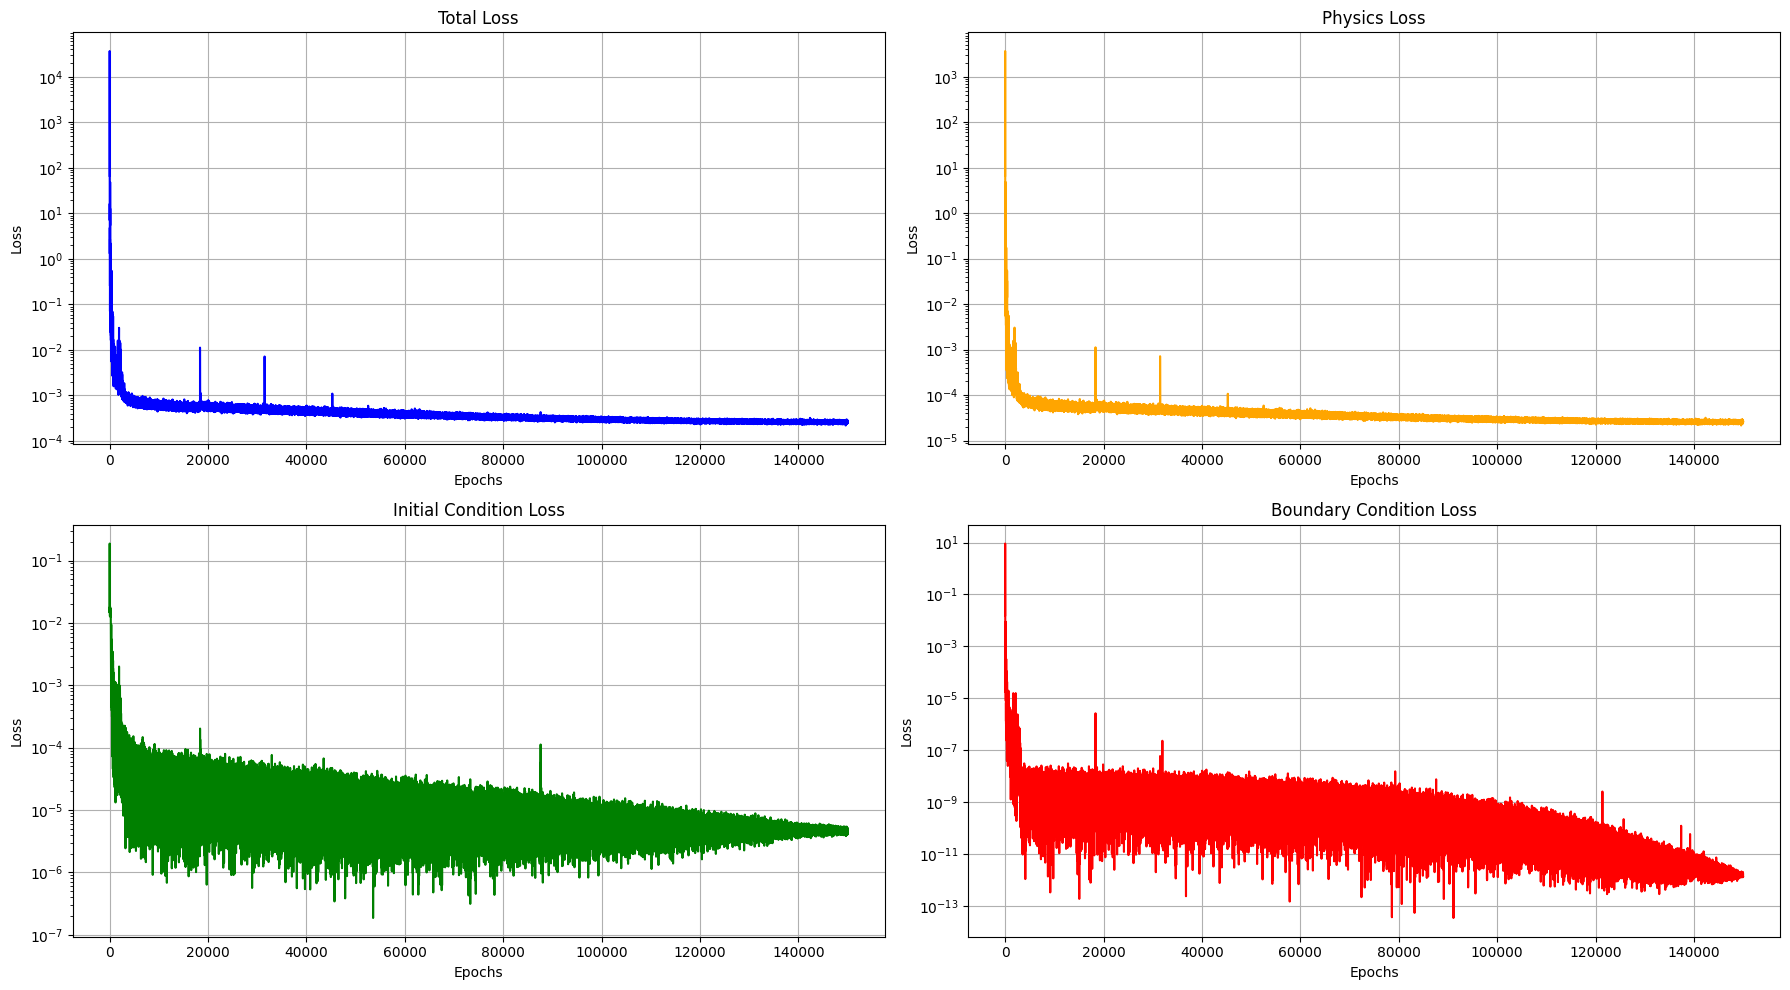

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()